<h1>
<center>CFRM 421/521, Spring 2022</center>
</h1>

<h1>
<center>[Insert your name here]</center>
</h1>

<h1>
<center>Homework 2</center>
</h1>

* **Due: Monday, May 2, 2022, 11:59 PM**


* Total marks: 41


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as one Jupyter notebook on Canvas and one PDF file on Gradescope.** The notebook must be already run, that is, make sure that you have run all your code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Random forest for time series data [13 marks]

In this question you will work with the NYSE dataset. Only 3 time series in this dataset will be use: `DJ_return` ($a_t$), `log_volatility` ($b_t$), and `log_volume` ($c_t$). Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/91091313/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf), which explains the meaning of the variables.

You want to predict the 1-step ahead value of `log_volume` $c_{t+1}$ using the previous values of this variable and the other two variables (`DJ_return` and `log_volatility`) up to 5 lags. So the features are $c_{t},\dots,c_{t-4},b_{t},\dots,b_{t-4},a_{t},\dots,a_{t-4}$.

If the data is stored in a file named `NYSE.csv` in your working directory, then loading the data can be done using the code below.

In [1]:
import os
import pandas as pd
data = pd.read_csv("NYSE.csv")

## (a) [3 marks]

Create the feature matrix `X` and the target variable `y`. Print at least the first 2 rows of `X` and `y` (it is acceptable that not every element of the rows are printed).

**[Add your solution here]**

In [2]:
import numpy as np

def ts_split(ts, feature_steps=5, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

In [3]:
DJ_return = ts_split(data['DJ_return'])[0]
log_volatility = ts_split(data['log_volatility'])[0]
log_volume, y = ts_split(data['log_volume'])

X =  np.hstack((log_volume, DJ_return, log_volatility))

In [4]:
X[:10]

array([[ 3.25730000e-02,  3.46202000e-01,  5.25306000e-01,
         2.10182000e-01,  4.41870000e-02, -4.46100000e-03,
         7.81300000e-03,  3.84500000e-03, -3.46200000e-03,
         5.68000000e-04, -1.31274026e+01, -1.17493047e+01,
        -1.16656090e+01, -1.16267724e+01, -1.17281302e+01],
       [ 3.46202000e-01,  5.25306000e-01,  2.10182000e-01,
         4.41870000e-02,  1.33246000e-01,  7.81300000e-03,
         3.84500000e-03, -3.46200000e-03,  5.68000000e-04,
        -1.08240000e-02, -1.17493047e+01, -1.16656090e+01,
        -1.16267724e+01, -1.17281302e+01, -1.08725263e+01],
       [ 5.25306000e-01,  2.10182000e-01,  4.41870000e-02,
         1.33246000e-01, -1.15280000e-02,  3.84500000e-03,
        -3.46200000e-03,  5.68000000e-04, -1.08240000e-02,
         1.24000000e-04, -1.16656090e+01, -1.16267724e+01,
        -1.17281302e+01, -1.08725263e+01, -1.09777968e+01],
       [ 2.10182000e-01,  4.41870000e-02,  1.33246000e-01,
        -1.15280000e-02,  1.60700000e-03, -3.46200000

In [5]:
y[:10]

array([[ 0.133246],
       [-0.011528],
       [ 0.001607],
       [-0.106437],
       [-0.138269],
       [-0.049635],
       [-0.043387],
       [ 0.053629],
       [ 0.104624],
       [-0.088976]])

## (b)  [4 marks]

Consider fitting a random forest to predict the 1-step ahead value of `log_volume`. The random forest must include the argument `random_state=42`, and it is useful to also include `n_jobs=-1` (you can use `n_job=-1` throughout this homework wherever it is avaliable). Use 3-fold time series CV, with the test set split 50% into a validation set and 50% into the actual test set, to tune the hyperparameters `n_estimators` taking the values  100, 500, 750, and the cost-complexity pruning parameter $\alpha$ taking the values $10^{-k}$, $k=0,1,\dots,9$. The performance measure is RMSE. Report the best hyperparameters.

**[Add your solution here]**

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

series_len = y.size

tscv = TimeSeriesSplit(n_splits=3)

# Hyperparamter combinations
n_estimators_list = [100, 500, 750]
ccp_alpha_list = 10**(-np.arange(0, 10).astype(float))

def time_series_valid_test(X, y, n_split, valid_or_test, optimal_par=None):
    tscv = TimeSeriesSplit(n_splits=n_split)
    rf_rmse = []
    i = 0
    for train_index, test_index in tscv.split(X):
        i += 1
        # Break test set into 50% validation set, 50% test set
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))

        # Split
        X_train, X_valid, X_test = X[train_index], X[valid_index], X[test_index]
        y_train, y_valid, y_test = y[train_index], y[valid_index], y[test_index]

        # Tuning
        if valid_or_test == "valid":
            for n_estimators in n_estimators_list:
                for ccp_alpha in ccp_alpha_list:
                    model_rf = RandomForestRegressor(random_state=42,
                               n_estimators=n_estimators, ccp_alpha=ccp_alpha, n_jobs=-1)
                    model_rf.fit(X_train, y_train.ravel())
                    y_val_rf = model_rf.predict(X_valid)
                    rf_rmse.append(np.sqrt(mean_squared_error(y_valid, y_val_rf)))

        # Evalulate on test set
        if valid_or_test == "test":
            model_rf = RandomForestRegressor(random_state=42,
                       n_estimators=optimal_par[0], ccp_alpha=optimal_par[1], n_jobs=-1)
            model_rf.fit(X_train, y_train.ravel())
            y_test_rf = model_rf.predict(X_test)
            rf_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_rf)))

            # Plot the prediction for the last CV fold
            if i == n_split:
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test_rf, label="1-step ahead prediction")
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test, label="True value")
                plt.legend(loc="upper left")

    # Average RMSE over CV folds
    if valid_or_test == "valid":
        rf_rmse = np.mean(np.array(rf_rmse).reshape(
            n_split, len(n_estimators_list)*len(ccp_alpha_list)), axis=0)
        return rf_rmse
    if valid_or_test == "test":
        rf_rmse = np.mean(rf_rmse)
        return rf_rmse, y_test_rf

In [7]:
rf_rmse = time_series_valid_test(X, y, 3, "valid")
ind = 0
for n_estimators in n_estimators_list:
    for ccp_alpha in ccp_alpha_list:
        print(["(n_estimators, ccp_alpha):",[n_estimators, ccp_alpha]])
        print(rf_rmse[ind])
        ind += 1

['(n_estimators, ccp_alpha):', [100, 1.0]]
0.2358102502325389
['(n_estimators, ccp_alpha):', [100, 0.1]]
0.2358102502325389
['(n_estimators, ccp_alpha):', [100, 0.01]]
0.1931776501341703
['(n_estimators, ccp_alpha):', [100, 0.001]]
0.1742571823815323
['(n_estimators, ccp_alpha):', [100, 0.0001]]
0.1614501523436291
['(n_estimators, ccp_alpha):', [100, 1e-05]]
0.16092212183444374
['(n_estimators, ccp_alpha):', [100, 1e-06]]
0.16126901713458971
['(n_estimators, ccp_alpha):', [100, 1e-07]]
0.16132852989129298
['(n_estimators, ccp_alpha):', [100, 1e-08]]
0.16134226586644118
['(n_estimators, ccp_alpha):', [100, 1e-09]]
0.1613426447569936
['(n_estimators, ccp_alpha):', [500, 1.0]]
0.23583279057420017
['(n_estimators, ccp_alpha):', [500, 0.1]]
0.23583279057420017
['(n_estimators, ccp_alpha):', [500, 0.01]]
0.19289278821198516
['(n_estimators, ccp_alpha):', [500, 0.001]]
0.1741139415851224
['(n_estimators, ccp_alpha):', [500, 0.0001]]
0.16109603191941044
['(n_estimators, ccp_alpha):', [500, 1e-

In [8]:
print(["(n_estimators, ccp_alpha):",[500, 1e-05]])

['(n_estimators, ccp_alpha):', [500, 1e-05]]


## (c)  [2 marks]

Using the same time series split as in (b), compute the RMSE of the best fitting model on the test set, and include a plot of the true values and predicted values on the test set of the last fold (the fold closest to the current time) of the CV.

**[Add your solution here]**

0.18695778279368594

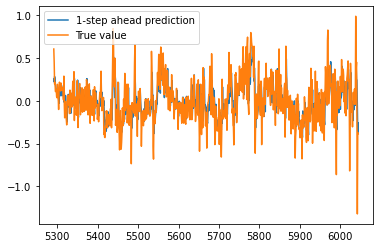

In [9]:
rf_rmse, y_test_rf = time_series_valid_test(X, y, 3, "test", [500, 1e-05])
rf_rmse

## (d) [2 marks]

It is often useful to check that your model is not worse than a very simple method of prediction. Compute the RMSE of a model that simply predicts the 1-step ahead value of `log_volume` $c_{t+1}$ as the current value $c_t$, and compare this to the best fitting random forest model.

**[Add your solution here]**

In [10]:
simple_rmse = np.sqrt(mean_squared_error(y[1:], y[0:-1]))
simple_rmse

0.18886372498700638

## (e) [2 marks]

Compute the feature importances of the best fitting model. Which feature is the most important and what is its feature importance value?

**[Add your solution here]**

In [11]:
best_model = RandomForestRegressor(random_state=42,
           n_estimators=500, ccp_alpha=1e-05, n_jobs=-1)
best_model.fit(X, y.ravel())

best_model.feature_importances_

array([0.05910464, 0.06276926, 0.04343883, 0.03711868, 0.52845434,
       0.03368364, 0.02979753, 0.03728229, 0.03897922, 0.06402235,
       0.01548615, 0.01227923, 0.01110293, 0.0125332 , 0.0139477 ])

In [12]:
max(best_model.feature_importances_)

0.5284543420578321

the current value of log_volume

# 2. SVM classification and regression [11 marks]

## (a) [2 marks]

In this question, a SVM is used for classification for the MNIST dataset. The following code loads the MNIST dataset, creates the test set, and to reduce training time, takes a random sample of 2000 points from the full training set to use as your actual training set stored in `X` and `y`. Do not shuffle the data and do not use a standard scaler.

Hint: Reading the solution to Question 9 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb) on the textbook website may help with this question.

In [13]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, cache=True)
mnist.target = mnist.target.astype(np.int8)
X_train = mnist["data"][:60000]
X_test  = mnist["data"][60000:]
y_train = mnist["target"][:60000]
y_test  = mnist["target"][60000:]

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

N = 2000
split_obj = StratifiedShuffleSplit(n_splits=1,
                               test_size=N/60000, random_state=42)
for other_idx, subsample_idx in split_obj.split(X_train, y_train):
    X = X_train[subsample_idx]
    y = y_train[subsample_idx]

**Task:** Consider fitting the linear SVM classifier (`LinearSVC`) with `max_iter=50000`. For this model, optimize the hyperparameter $C$ using 3-fold CV over the values $10^{-k}$, $k=0,1,\dots,9$, where the performance measure is accuracy. What is the best $C$ and what is the accuracy in this case?

**[Add your solution here]**

In [15]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid = {
     'C': list(10**(-np.arange(0, 10).astype(float)))
  }

svm_clf = LinearSVC(loss='hinge', max_iter=50000, random_state=42)
grid_search = GridSearchCV(svm_clf, param_grid, cv=3,
                           scoring='accuracy',
                           n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=LinearSVC(loss='hinge', max_iter=50000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                               1e-07, 1e-08, 1e-09]},
             scoring='accuracy')

In [16]:
grid_search.best_params_

{'C': 1e-06}

In [17]:
grid_search.best_score_

0.8569941755848802

## (b) [2 marks]

**Task:** Now consider fitting a SVM with a Gaussian RBF kernel and `max_iter=50000`. For this model, optimize the hyperparameters $C$ over the distrbution `uniform(1,10)` and $\gamma$ over the distribution `reciprocal(0.001, 0.1)` with 10 random samples. Again, use 3-fold CV and the performance measure is accuracy. What are the best hyperparameters and what is the accuracy in this case?

**[Add your solution here]**

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import reciprocal

param_distribs = {
        'C': uniform(1, 10),
        'gamma': reciprocal(0.001, 0.1),
    }

svm_rbf = SVC(max_iter=50000, kernel='rbf')
rnd_search = RandomizedSearchCV(svm_rbf, param_distributions=param_distribs,
                                n_iter=10, cv=3, scoring='accuracy', random_state=42,
                                n_jobs=-1)
rnd_search.fit(X, y)

RandomizedSearchCV(cv=3, estimator=SVC(max_iter=50000), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000176D4935D30>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000176D477D1F0>},
                   random_state=42, scoring='accuracy')

In [19]:
rnd_search.best_params_

{'C': 4.745401188473625, 'gamma': 0.07969454818643928}

In [20]:
rnd_search.best_score_

0.11250005627816723

## (c) [2 mark]

**Task:** Choose the best model in (a) and (b). Then for this model, evaluate the accuracy on the test set, which is stored in `X_test` and `y_test`.

**[Add your solution here]**

In [21]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.8855

## (d) [3 marks]

Consider the California housing data from Homework 1 using the same training and test set there. The data is obtained using the code below, which comes from Homework 1, and the training set is stored in `X` and `y`. Do not shuffle the data.

Hint: Reading the solution to Question 10 in the Chapter 5 [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb) on the textbook website may help with this question.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import os
import tarfile
from six.moves import urllib
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import StratifiedShuffleSplit

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()

data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
num_features = X_raw.drop("ocean_proximity", axis=1)
num_attribs = list(num_features)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X = full_pipeline.fit_transform(X_raw)
X_test_raw = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test = full_pipeline.transform(X_test_raw)

**Task:** Consider SVM regression with a Gaussian RBF kernel and a sigmoid kernel with `max_iter=50000`. For both models, use randomized search to choose good hyperparameter values for `C` and `gamma`, and set the arguement `random_state=42`. For both models, optimize the hyperparameters $C$ over the distrbution `uniform(1,10)` and $\gamma$ over the distribution `reciprocal(0.001, 0.1)` with 10 random samples. Again, use 3-fold CV and the performance measure is MSE. What are the best hyperparameters and what is the MSE in this case?

**[Add your solution here]**

In [25]:
from sklearn.svm import SVR

param_distribs = {
        'C': uniform(1, 10),
        'gamma': reciprocal(0.001, 0.1),
    }

svr_rbf = SVR(max_iter=50000, kernel='rbf')
rnd_search_rbf = RandomizedSearchCV(svr_rbf, param_distributions=param_distribs,
                                n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42,
                                n_jobs=-1)
rnd_search_rbf.fit(X, y)

RandomizedSearchCV(cv=3, estimator=SVR(max_iter=50000), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000176D4997A90>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000176D477D7C0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [26]:
rnd_search_rbf.best_params_

{'C': 4.745401188473625, 'gamma': 0.07969454818643928}

In [28]:
-rnd_search_rbf.best_score_

13877012057.239176

In [29]:
param_distribs = {
        'C': uniform(1, 10),
        'gamma': reciprocal(0.001, 0.1),
    }

svr_sig = SVR(max_iter=50000, kernel='sigmoid')
rnd_search_sig = RandomizedSearchCV(svr_sig, param_distributions=param_distribs,
                                n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42,
                                n_jobs=-1)
rnd_search_sig.fit(X, y)

RandomizedSearchCV(cv=3, estimator=SVR(kernel='sigmoid', max_iter=50000),
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000176D4935400>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000176D4935700>},
                   random_state=42, scoring='neg_mean_squared_error')

In [30]:
rnd_search_sig.best_params_

{'C': 4.745401188473625, 'gamma': 0.07969454818643928}

In [31]:
-rnd_search_sig.best_score_

13744315287.792427

## (e) [2 marks]

**Task:** Choose the best model in (d). Then for this model, evaluate the RMSE on the test set, which is stored in `X_test` and `y_test`.

In [32]:
from sklearn.metrics import mean_squared_error

y_pred = rnd_search_sig.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

114741.28850451492

**[Add your solution here]**

# 3. Voting Classifiers [8 marks]
## (a)  [4 marks]

Consider the MNIST dataset. To save computational time, split it into a smaller training set (the first 5000 observations) and a validation set (the next 1000 observations) as given by the following code.

In [34]:
N = 5000
M = 6000
X_train = mnist["data"][:N]
X_val  = mnist["data"][N:M]
y_train = mnist["target"][:N]
y_val = mnist["target"][N:M]

Do not shuffle the data and do not use a standard scaler. Train the following classifiers on the training set:

(i) a random forest classifier with arguments `n_estimators=100, n_jobs=-1, random_state=42`,

(ii) an extra-trees classifier with arguments `n_estimators=100, n_jobs=-1, random_state=42`,

(iii) an AdaBoost classifier `n_estimators=50, learning_rate=0.2, random_state=42`,

(iv) a gradient boosting classifier using the class `GradientBoostingClassifier()` with arguments `max_depth=2, n_estimators=10, learning_rate=0.25, random_state=42`.

Report the accuracy of each trained classifier on the validation set.

**[Add your solution here]**

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
et_clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)
ab_clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.2, random_state=42)
gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=10, learning_rate=0.25, random_state=42)

rf_clf.fit(X_train, y_train)
et_clf.fit(X_train, y_train)
ab_clf.fit(X_train, y_train)
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.25, max_depth=2, n_estimators=10,
                           random_state=42)

In [42]:
y_pred_rf = rf_clf.predict(X_val)
y_pred_et = et_clf.predict(X_val)
y_pred_ab = ab_clf.predict(X_val)
y_pred_gb = gb_clf.predict(X_val)

In [43]:
accuracy_score(y_pred_rf, y_val)

0.939

In [44]:
accuracy_score(y_pred_et, y_val)

0.947

In [45]:
accuracy_score(y_pred_ab, y_val)

0.736

In [46]:
accuracy_score(y_pred_gb, y_val)

0.834

## (b)  [4 marks]
Train a hard-voting and a soft-voting ensemble classifier based on the models in (a). Evaluate each voting classifier on the validation set. Comment on whether the performance of the ensemble model is better or worse than the individual models in (a) and why that is the case.

**[Add your solution here]**

In [47]:
from sklearn.ensemble import VotingClassifier
voting_clf_hard = VotingClassifier(
    estimators=[('rf', rf_clf), ('et', et_clf), ('ab', ab_clf), ('gb', gb_clf)],
    voting='hard')

In [48]:
voting_clf_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('et',
                              ExtraTreesClassifier(n_jobs=-1, random_state=42)),
                             ('ab',
                              AdaBoostClassifier(learning_rate=0.2,
                                                 random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.25,
                                                         max_depth=2,
                                                         n_estimators=10,
                                                         random_state=42))])

In [49]:
y_pred_hard = voting_clf_hard.predict(X_val)
accuracy_score(y_pred_hard, y_val)

0.923

In [51]:
voting_clf_soft = VotingClassifier(
    estimators=[('rf', rf_clf), ('et', et_clf), ('ab', ab_clf), ('gb', gb_clf)],
    voting='soft')

In [52]:
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('et',
                              ExtraTreesClassifier(n_jobs=-1, random_state=42)),
                             ('ab',
                              AdaBoostClassifier(learning_rate=0.2,
                                                 random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.25,
                                                         max_depth=2,
                                                         n_estimators=10,
                                                         random_state=42))],
                 voting='soft')

In [53]:
y_pred_soft = voting_clf_soft.predict(X_val)
accuracy_score(y_pred_soft, y_val)

0.926

# 4. Stacking [9 marks]

We continue with the setting of Question 3. The training set, validation set and test set are the same. In Question 3, we have used predetermined rules (that is, hard-voting and soft-voting) to build the ensemble prediction. **Stacking** is an ensemble method in which you train a model (called a **blender**) to aggregate the result of each predictor into an ensemble prediction.

Hint: Reading the subsection "Stacking" in Chapter 7 of the textbook and the solution to Question 9 in the Chapter 7 [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb) on the textbook website may help with this question.

## (a)  [3 marks]

For each of the four classifiers in Question 3(a), make 5000 clean predictions on the training set with 3-fold cross validation using `sklearn.model_selection.cross_val_predict()`. You should end up with four predictions per observation. Print at least the first 5 rows of `pred`. Next, apply one-hot encoding to `pred` since these predictions are class labels.

**[Add your solution here]**

In [78]:
from sklearn.model_selection import cross_val_predict

rf_pred = cross_val_predict(rf_clf, X_train, y_train, cv=3,  n_jobs=-1)
et_pred = cross_val_predict(et_clf, X_train, y_train, cv=3,  n_jobs=-1)
ab_pred = cross_val_predict(ab_clf, X_train, y_train, cv=3,  n_jobs=-1)
gb_pred = cross_val_predict(gb_clf, X_train, y_train, cv=3,  n_jobs=-1)

In [79]:
pred =  np.stack((rf_pred, et_pred, ab_pred, gb_pred), axis=1)
pred[:10]

array([[5, 5, 3, 3],
       [0, 0, 5, 0],
       [4, 4, 4, 4],
       [1, 1, 1, 1],
       [9, 9, 9, 9],
       [2, 2, 2, 2],
       [1, 1, 1, 1],
       [3, 3, 3, 3],
       [1, 1, 1, 1],
       [4, 4, 4, 4]], dtype=int8)

In [80]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
pred = cat_encoder.fit_transform(pred)
pred[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
   

## (b) [3 marks]
Use the predictions in (a) as features and the actual label of the observations as the target. Train a random forest classifier on the training set with the parameters `n_estimators=100, random_state=42`.  This classifier is a blender. 

**[Add your solution here]**

In [81]:
blender = RandomForestClassifier(n_estimators=100, random_state=42)
blender.fit(pred, y_train)

RandomForestClassifier(random_state=42)

## (c) [3 marks]

Obtain the predictions of the blender on the validation set by feeding predictions on the validation set from the four classifiers in Question 3(a) into the blender trained in Question 4(b). Do not retrain the blender. These are called stacking predictions. Report the accuracy of your stacking predictions on the validation set and compare this to the results in Question 3(b).

**[Add your solution here]**

In [82]:
rf_pred_val = rf_clf.predict(X_val)
et_pred_val = et_clf.predict(X_val)
ab_pred_val = ab_clf.predict(X_val)
gb_pred_val = gb_clf.predict(X_val)

pred_val =  np.stack((rf_pred_val, et_pred_val, ab_pred_val, gb_pred_val), axis=1)
pred_val = cat_encoder.transform(pred_val)

In [83]:
stacking_pred = blender.predict(pred_val)

In [84]:
accuracy_score(stacking_pred, y_val)

0.947